In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from action_surface import (
    generate_synthetic_data,
    fit_action_surface,
    plot_dose_response_curves,
    action_surface_response,
    ScatterContourPlotter,
    WAVELENGTH_COLORS,
    
)

sns.set_context('talk')

%load_ext autoreload
%autoreload 2


# Comprehensive Action Surface Analysis

This notebook demonstrates the complete action surface workflow:
1. Generate synthetic data
2. Fit the action surface model
3. Visualize results with multiple plot types
4. Compare variants


## Step 1: Generate Synthetic Data


In [3]:
print("Generating synthetic data...")

true_params = {
    'lambda_max': 510,
    'sigma': 40,
    'K': 0.5,
    'n': 1.0,
    'amp_max': 1200,
    'baseline': 50,
}

data = generate_synthetic_data(
    wavelengths=[440, 475, 510, 555, 575, 637, 748],
    irradiances=np.logspace(-3, 0.5, 10),
    noise_level=0.1,
    n_replicates=3,
    seed=42,
    **true_params
)

print(f"Generated {len(data)} data points")
print(f"Wavelengths: {sorted(data['wavelength'].unique())}")
data


Generating synthetic data...
Generated 210 data points
Wavelengths: [np.int64(440), np.int64(475), np.int64(510), np.int64(555), np.int64(575), np.int64(637), np.int64(748)]


,wavelength,irradiance,peak_current,replicate,true_response
0,440,0.001000,53.028153,0,50.518812
1,440,0.001000,49.820317,1,50.518812
2,440,0.001000,53.790858,2,50.518812
3,440,0.002448,59.077979,0,51.269483
4,440,0.002448,50.068991,1,51.269483
...,...,...,...,...,...
205,748,1.291550,45.310932,1,50.000064
206,748,1.291550,52.575243,2,50.000064
207,748,3.162278,52.569094,0,50.000156
208,748,3.162278,52.575402,1,50.000156


## Step 2: Fit Action Surface Model


In [4]:
print("Fitting action surface model...")

results = fit_action_surface(data)
fitted_params = results['parameters_avg']
metrics = results['mean_performance_metrics']

print(f"\nFitted Parameters:")
print(f"  λ_max: {fitted_params['lambda_max']:.1f} nm")
print(f"  σ: {fitted_params['sigma']:.1f} nm")
print(f"  K: {fitted_params['K']:.3f} mW/mm²")
print(f"  n: {fitted_params['n']:.2f}")
print(f"  amp_max: {10**fitted_params['log10_amp_max']:.0f} pA")
print(f"  baseline: {fitted_params['baseline']:.0f} pA")

print(f"\nPerformance Metrics:")
print(f"  R²: {metrics['r2_mean']:.3f} ± {metrics['r2_std']:.3f}")


Fitting action surface model...

Fitted Parameters:
  λ_max: 510.4 nm
  σ: 39.5 nm
  K: 0.511 mW/mm²
  n: 1.01
  amp_max: 1225 pA
  baseline: 51 pA

Performance Metrics:
  R²: 0.987 ± 0.006


## Step 3: Visualizations


### Dose-Response Curves
Shows peak current (absolute values) for each wavelength with T200 threshold lines marked


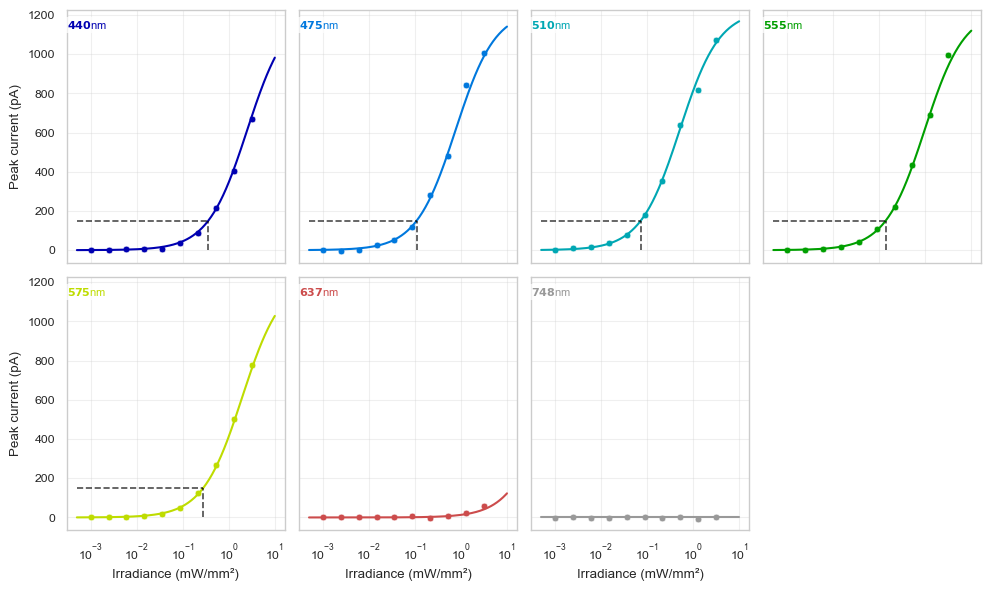

In [5]:
fig1 = plot_dose_response_curves(data=data, model_params=fitted_params, threshold_current=200, normalize=False)
fig1.tight_layout()
plt.show()


### Data and Action Surface Comparison
Three subplots showing: (A) Raw data scatter, (B) Action surface alone, (C) Action surface with data overlay


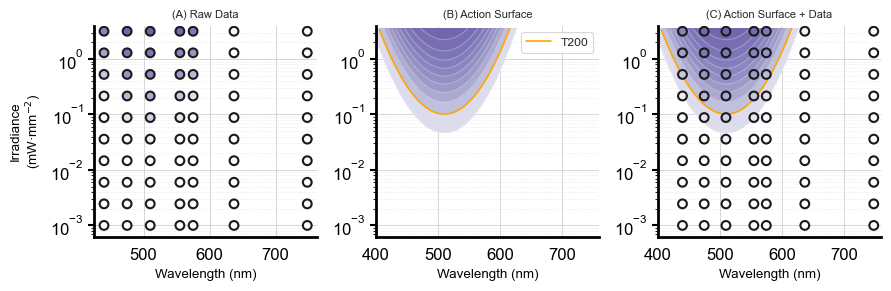

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# Subplot A: Scatter plot using ScatterContourPlotter (no contours, just data)
plotter = ScatterContourPlotter()
plotter.config['fill_contours'] = False
plotter.config['line_contours'] = False
plotter.config['y_axis_major_ticks'] = 10
plotter.clear_threshold_lines()
fig_temp_a, ax_temp_a = plotter.plot(
    params=fitted_params,
    single_exp=data,
    ax=axes[0],
    figsize=None,
    title='(A) Raw Data',
)
axes[0].tick_params(labelsize=12)

plotter.config['fill_contours'] = True
plotter.config['line_contours'] = True
plotter.add_threshold_line(
    current=200,
    line_color="orange",
    marker_color=None,
    line_style="-",
    show_line=True,
    label="T200",
)
fig_temp_b, ax_temp_b = plotter.plot(
    params=fitted_params,
    single_exp=None,
    ax=axes[1],
    figsize=None,
    show_ylabel=False,
    title='(B) Action Surface',
)
axes[1].tick_params(labelsize=12)
axes[1].legend()

fig_temp_c, ax_temp_c = plotter.plot(
    params=fitted_params,
    single_exp=data,
    ax=axes[2],
    figsize=None,
    show_ylabel=False,
    title='(C) Action Surface + Data',
)

axes[2].tick_params(labelsize=12)

fig.tight_layout()
plt.show()


# Real Data Examples

Now let's fit action surfaces for real opsin data from patch-clamp experiments.

## Load Real Data

The dataset contains wavelength-irradiance-response measurements from multiple opsin variants.


In [7]:

# Load the real experimental data
real_data = pd.read_csv('wachr_demo_data.csv', index_col=0)
# Display basic info
print(f"\nOpsins in dataset: {real_data['opsin_protein_name'].unique()}")
real_data


Opsins in dataset: ['ChRmine' 'GtCCR4' 'CoChR_H94E_L112C_K264T' 'ex3mV1Co' 'WiChR_F240A'
 'ChRger2' 'HcKCR1_Y222A']


,recording_id,wavelength,irradiance,peak_current,plasmid_name,opsin_protein_name
0,E0307P5T2,440.0,0.00125,90.0,EF1A__ChRmine__kG-mScr-kSE,ChRmine
1,E0307P5T2,440.0,0.00388,85.0,EF1A__ChRmine__kG-mScr-kSE,ChRmine
2,E0307P5T2,440.0,0.01012,85.0,EF1A__ChRmine__kG-mScr-kSE,ChRmine
3,E0307P5T2,440.0,0.02384,90.0,EF1A__ChRmine__kG-mScr-kSE,ChRmine
4,E0307P5T2,440.0,0.06245,85.0,EF1A__ChRmine__kG-mScr-kSE,ChRmine
...,...,...,...,...,...,...
485,E0624P7T2,748.0,0.10873,60.0,EF1A__LR_HcKCR1_Y222A__kG-mScr-kSE,HcKCR1_Y222A
486,E0624P7T2,748.0,0.21161,50.0,EF1A__LR_HcKCR1_Y222A__kG-mScr-kSE,HcKCR1_Y222A
487,E0624P7T2,748.0,0.41054,55.0,EF1A__LR_HcKCR1_Y222A__kG-mScr-kSE,HcKCR1_Y222A
488,E0624P7T2,748.0,0.79278,50.0,EF1A__LR_HcKCR1_Y222A__kG-mScr-kSE,HcKCR1_Y222A


## Fit Action Surfaces for Each Opsin

Let's fit the action surface model to each opsin variant.


In [8]:
# Fit each opsin separately
opsin_results = {}

for opsin in real_data['opsin_protein_name'].unique():
    print(f"\n{'='*60}")
    print(f"Fitting {opsin}...")
    print(f"{'='*60}")
    
    # Get data for this opsin
    opsin_data = real_data[real_data['opsin_protein_name'] == opsin].copy()
    
    # Fit the model
    results = fit_action_surface(opsin_data)
    opsin_results[opsin] = results
    
    # Display fitted parameters
    params = results['parameters_avg']
    metrics = results['mean_performance_metrics']
    
    print(f"\nFitted Parameters:")
    print(f"  λ_max: {params['lambda_max']:.1f} nm")
    print(f"  σ (bandwidth): {params['sigma']:.1f} nm")
    print(f"  K (half-max): {params['K']:.4f} mW/mm²")
    print(f"  n (Hill coefficient): {params['n']:.2f}")
    print(f"  amp_max: {10**params['log10_amp_max']:.0f} pA")
    print(f"  baseline: {params['baseline']:.0f} pA")
    
    print(f"\nModel Performance:")
    print(f"  R²: {metrics['r2_mean']:.3f} ± {metrics['r2_std']:.3f}")

print(f"\n{'='*60}")
print(f"All {len(opsin_results)} opsins fitted successfully!")
print(f"{'='*60}")



Fitting ChRmine...

Fitted Parameters:
  λ_max: 524.6 nm
  σ (bandwidth): 37.2 nm
  K (half-max): 0.2289 mW/mm²
  n (Hill coefficient): 1.03
  amp_max: 1153 pA
  baseline: 79 pA

Model Performance:
  R²: 0.979 ± 0.007

Fitting GtCCR4...

Fitted Parameters:
  λ_max: 532.3 nm
  σ (bandwidth): 37.8 nm
  K (half-max): 0.4622 mW/mm²
  n (Hill coefficient): 1.16
  amp_max: 969 pA
  baseline: 131 pA

Model Performance:
  R²: 0.975 ± 0.005

Fitting CoChR_H94E_L112C_K264T...

Fitted Parameters:
  λ_max: 461.9 nm
  σ (bandwidth): 32.8 nm
  K (half-max): 0.2572 mW/mm²
  n (Hill coefficient): 0.93
  amp_max: 3000 pA
  baseline: 71 pA

Model Performance:
  R²: 0.991 ± 0.002

Fitting ex3mV1Co...

Fitted Parameters:
  λ_max: 540.2 nm
  σ (bandwidth): 38.1 nm
  K (half-max): 0.2361 mW/mm²
  n (Hill coefficient): 0.98
  amp_max: 2063 pA
  baseline: 73 pA

Model Performance:
  R²: 0.971 ± 0.015

Fitting WiChR_F240A...

Fitted Parameters:
  λ_max: 478.7 nm
  σ (bandwidth): 39.9 nm
  K (half-max): 0.1615

## Dose-Response Curves for Real Data

Show the dose-response curves for each wavelength with fitted model.


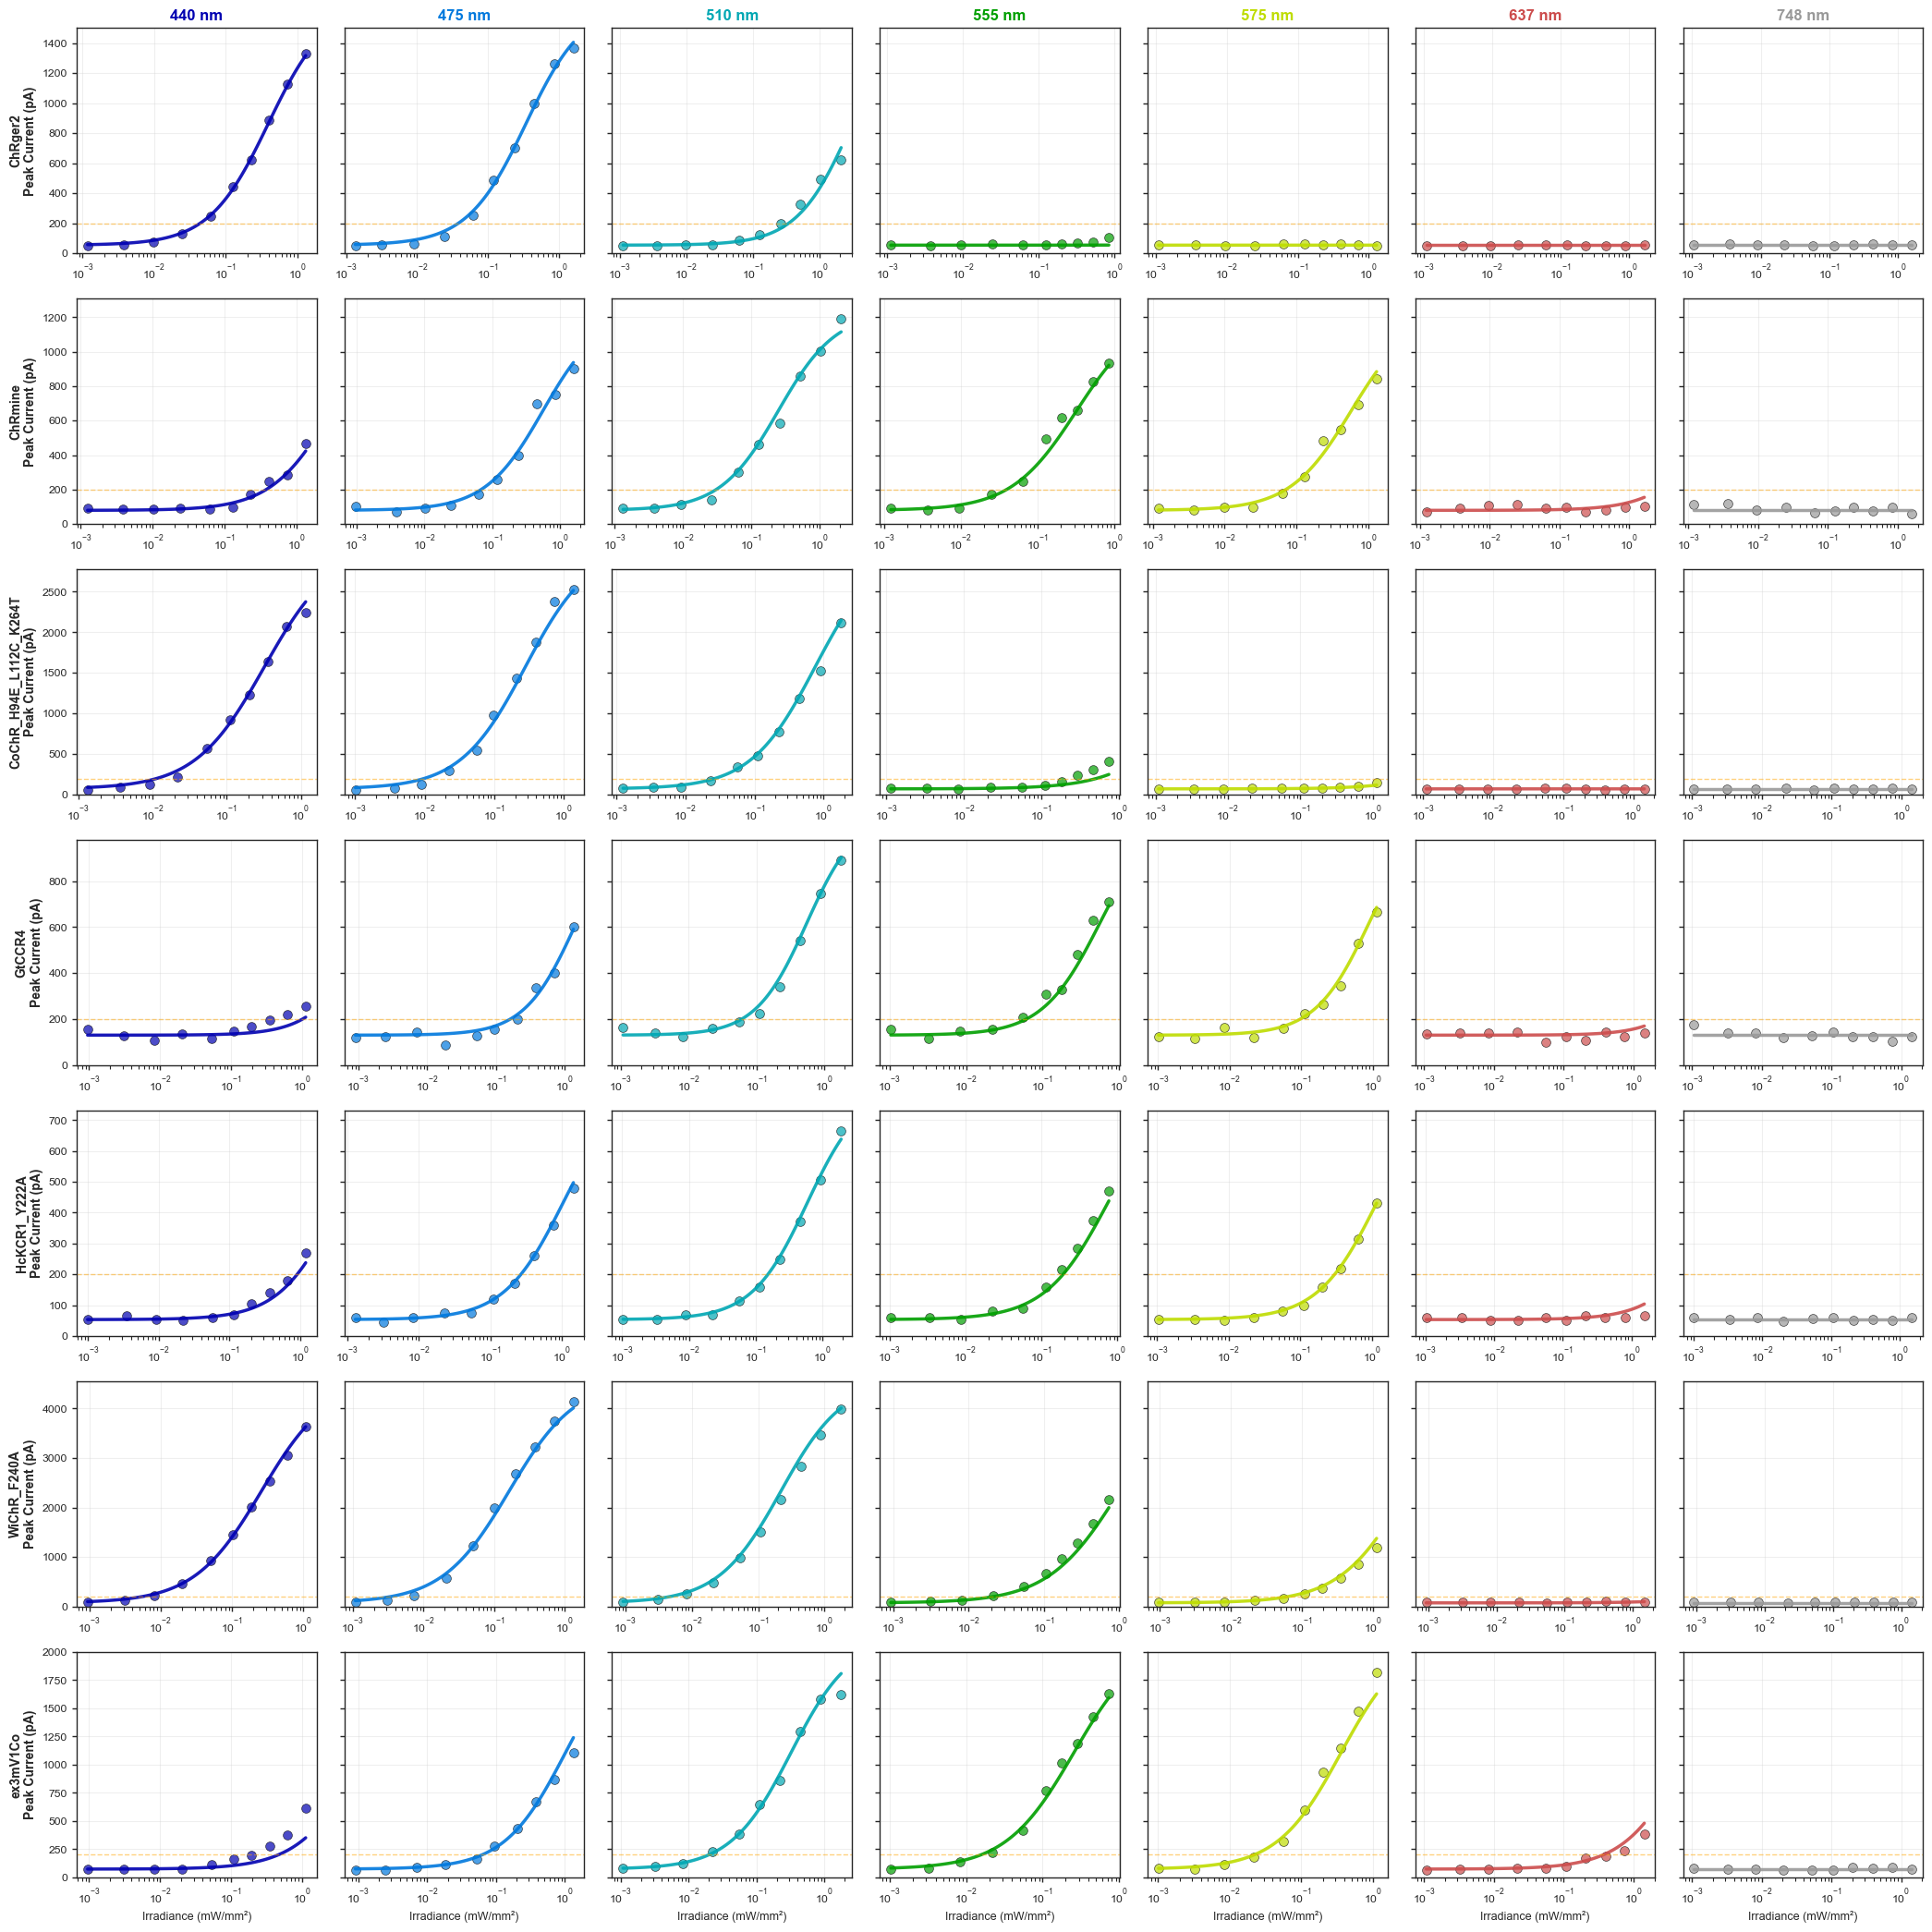

In [9]:

# Plot dose-response curves in a grid: one subplot per wavelength per opsin


# Get all opsins and wavelengths
opsins = sorted(opsin_results.keys())
all_wavelengths = sorted(real_data['wavelength'].unique())
n_opsins = len(opsins)
n_wavelengths = len(all_wavelengths)

# Create grid of subplots
fig_dr, axes_dr = plt.subplots(n_opsins, n_wavelengths, 
                                figsize=(3*n_wavelengths, 3*n_opsins), sharey='row',
                                squeeze=False)

# Plot each opsin × wavelength combination
for i, opsin in enumerate(opsins):
    params = opsin_results[opsin]['parameters_avg']
    opsin_data = real_data[real_data['opsin_protein_name'] == opsin]
    
    for j, wl in enumerate(all_wavelengths):
        ax = axes_dr[i, j]
        wl_data = opsin_data[opsin_data['wavelength'] == wl]
        color = WAVELENGTH_COLORS.get(int(wl), 'gray')
        
        if len(wl_data) > 0:
            # Plot data points
            ax.scatter(wl_data['irradiance'], wl_data['peak_current'], 
                      color=color, alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
            
            # Plot fitted curve
            irr_range = np.logspace(np.log10(wl_data['irradiance'].min()), 
                                   np.log10(wl_data['irradiance'].max()), 100)
            
            # Create wavelength array matching irradiance range
            wl_array = np.full_like(irr_range, wl)
            fitted_response = action_surface_response(
                data=(wl_array, irr_range),
                K=params['K'],
                n=params['n'],
                log10_amp_max=params['log10_amp_max'],
                lambda_max=params['lambda_max'],
                sigma=params['sigma'],
                baseline=params['baseline']
            )
            ax.plot(irr_range, fitted_response, color=color, linewidth=2.5, alpha=0.9)
            
            # Add threshold line
            ax.axhline(200, color='orange', linestyle='--', linewidth=1, alpha=0.5)
        
        # Formatting
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        
        # Column titles (wavelengths) on top row
        if i == 0:
            ax.set_title(f'{int(wl)} nm', fontsize=12, fontweight='bold', color=color)
        
        # Row labels (opsins) on left column
        if j == 0:
            ax.set_ylabel(f'{opsin}\nPeak Current (pA)', fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel('')
        
        # X-axis labels on bottom row
        if i == n_opsins - 1:
            ax.set_xlabel('Irradiance (mW/mm²)', fontsize=9)
        else:
            ax.set_xlabel('')
        
        # Set consistent y-axis limits per opsin for easier comparison
        ax.set_ylim(bottom=0, top=opsin_data['peak_current'].max() * 1.1)


fig_dr.tight_layout()
plt.show()


## Detailed View: Individual Opsin Analysis

Let's create detailed visualizations for each opsin showing data, action surface, and overlay.


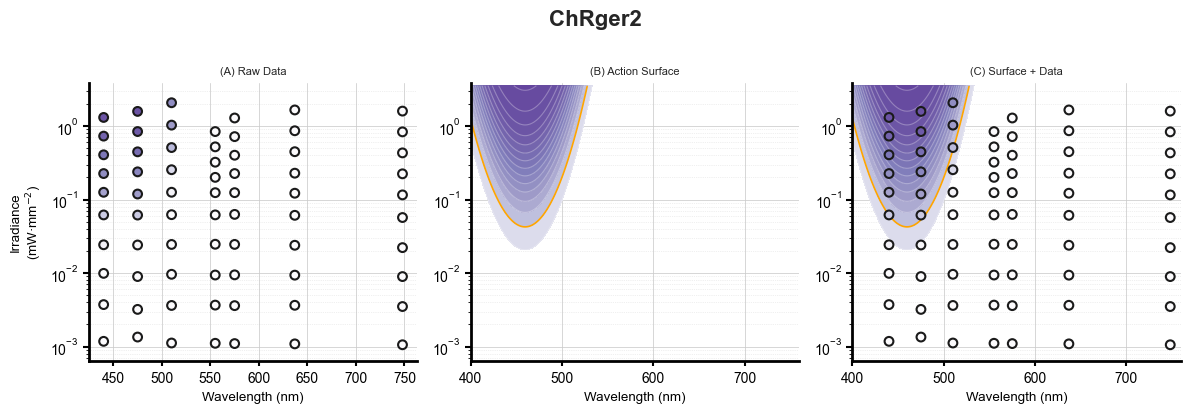

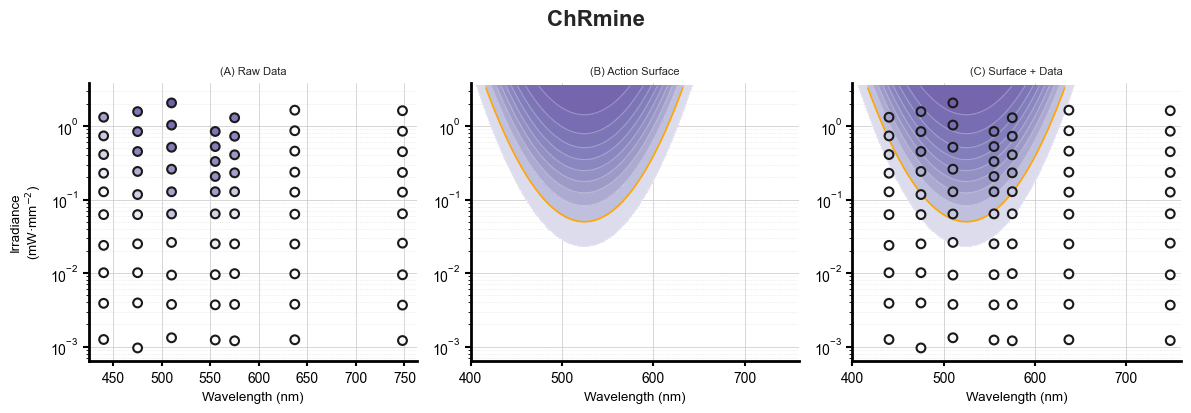

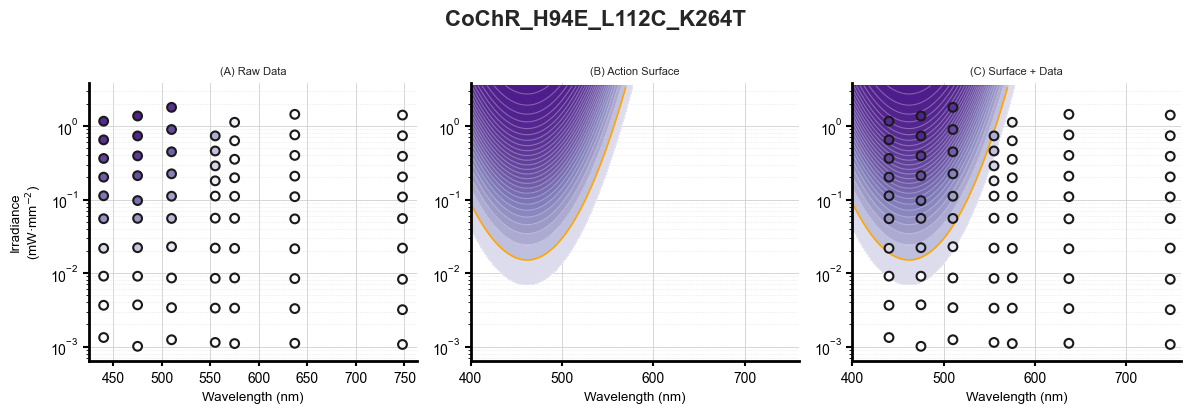

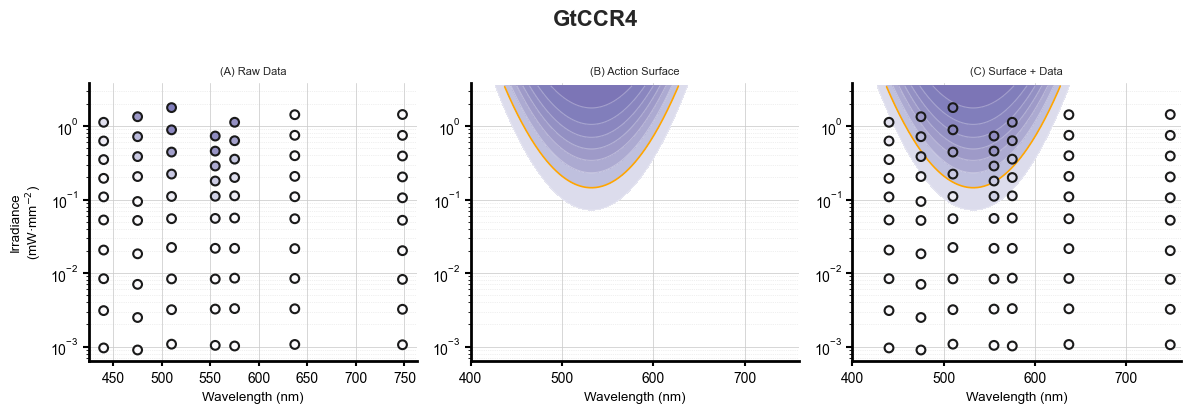

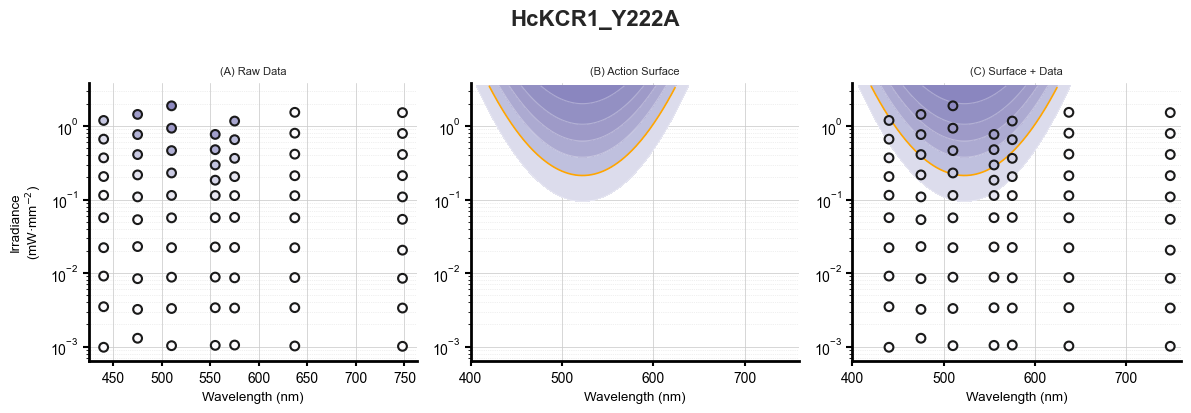

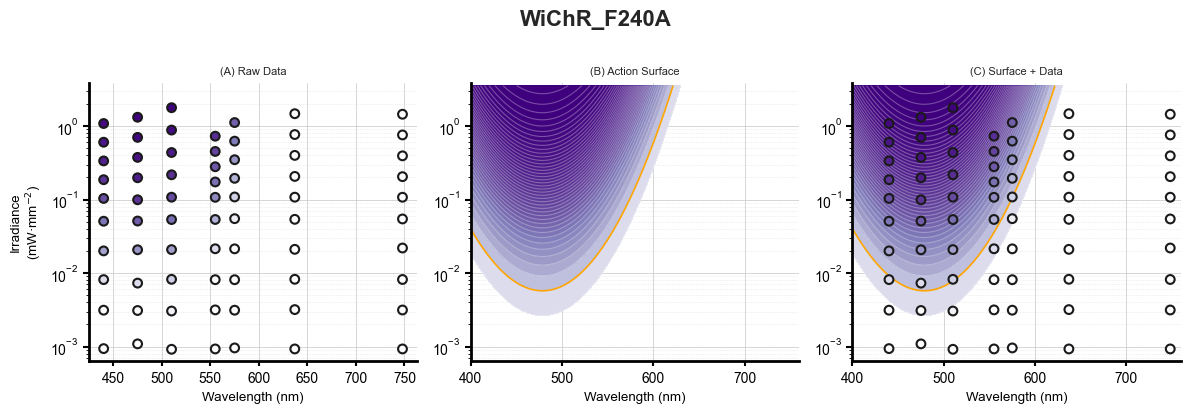

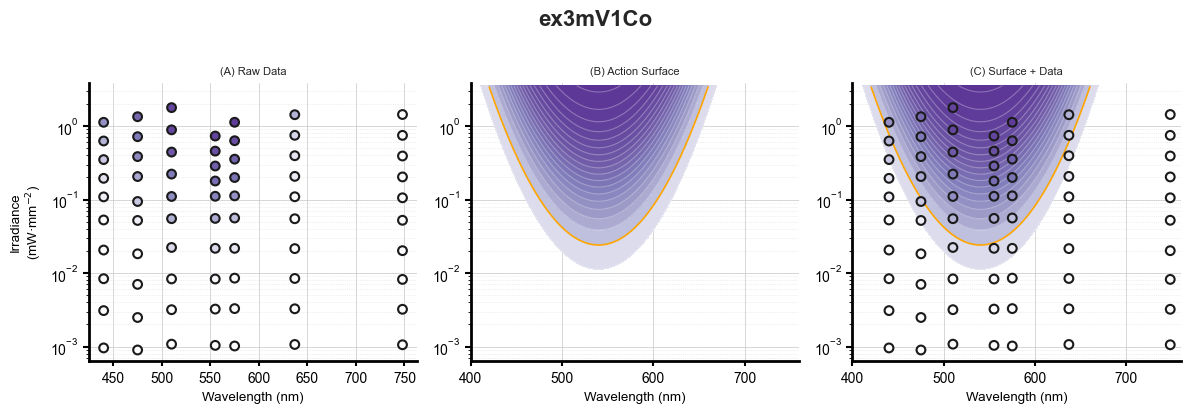

In [10]:
# Create detailed 3-panel view for each opsin
for opsin in sorted(opsin_results.keys()):
    
    params = opsin_results[opsin]['parameters_avg']
    opsin_data = real_data[real_data['opsin_protein_name'] == opsin]
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    
    # Panel A: Raw data only
    plotter_a = ScatterContourPlotter()
    plotter_a.config['fill_contours'] = False
    plotter_a.config['line_contours'] = False
    plotter_a.config['y_axis_major_ticks'] = 10
    plotter_a.clear_threshold_lines()
    fig_temp_a, ax_temp_a = plotter_a.plot(
        params=params,
        single_exp=opsin_data,
        ax=axes[0],
        figsize=None,
        title='(A) Raw Data',
    )
    axes[0].tick_params(labelsize=10)
    
    # Panel B: Action surface only
    plotter_b = ScatterContourPlotter()
    plotter_b.config['y_axis_major_ticks'] = 10
    fig_temp_b, ax_temp_b = plotter_b.plot(
        params=params,
        single_exp=None,
        ax=axes[1],
        figsize=None,
        show_ylabel=False,
        title='(B) Action Surface',
    )
    axes[1].tick_params(labelsize=10)
    
    # Panel C: Action surface with data overlay
    plotter_c = ScatterContourPlotter()
    plotter_c.config['y_axis_major_ticks'] = 10
    fig_temp_c, ax_temp_c = plotter_c.plot(
        params=params,
        single_exp=opsin_data,
        ax=axes[2],
        figsize=None,
        show_ylabel=False,
        title='(C) Surface + Data',
    )
    axes[2].tick_params(labelsize=10)
    
    # Add overall title
    fig.suptitle(f'{opsin}', fontsize=16, fontweight='bold', y=1.02)
    
    fig.tight_layout()
    plt.show()


## Summary: Compare Opsin Properties

Compare key parameters across all tested opsins.


In [11]:
# Create summary comparison table
summary_data = []

for opsin in sorted(opsin_results.keys()):
    params = opsin_results[opsin]['parameters_avg']
    metrics = opsin_results[opsin]['mean_performance_metrics']
    
    summary_data.append({
        'Opsin': opsin,
        'λ_max (nm)': f"{params['lambda_max']:.1f}",
        'σ (nm)': f"{params['sigma']:.1f}",
        'K (mW/mm²)': f"{params['K']:.4f}",
        'n': f"{params['n']:.2f}",
        'amp_max (pA)': f"{10**params['log10_amp_max']:.0f}",
        'baseline (pA)': f"{params['baseline']:.0f}",
        'R²': f"{metrics['r2_mean']:.3f}",
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("OPSIN COMPARISON SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)



OPSIN COMPARISON SUMMARY
                 Opsin λ_max (nm) σ (nm) K (mW/mm²)    n amp_max (pA) baseline (pA)    R²
               ChRger2      459.7   22.9     0.2714 1.06         1616            55 0.969
               ChRmine      524.6   37.2     0.2289 1.03         1153            79 0.979
CoChR_H94E_L112C_K264T      461.9   32.8     0.2572 0.93         3000            71 0.991
                GtCCR4      532.3   37.8     0.4622 1.16          969           131 0.975
          HcKCR1_Y222A      522.6   43.2     0.5606 1.05          756            53 0.984
           WiChR_F240A      478.7   39.9     0.1615 0.92         4508            76 0.993
              ex3mV1Co      540.2   38.1     0.2361 0.98         2063            73 0.971
